### Import libraries:

In [1]:
# Data analysis
import pandas as pd
# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation
from sklearn.utils import shuffle
# use seed to specify random sequence (make random consistent)
seed = 2018
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Scoring parameter
from sklearn.metrics import mean_absolute_error

In [4]:
# Try to read .csv file in case the files are already downloaded once
dataset_test  = pd.read_csv('data\wineQuality_val.data', sep = ",")
dataset_train = pd.read_csv('data\wineQuality_train.data', sep = ",")

dataset = pd.concat([dataset_test, dataset_train])


n_test = 100
dataset_test  = dataset_test[  : n_test]
dataset_train = dataset_train[: n_test]
#.reset_index(drop=True)

#Display the first 3 rows to get a feel of the data
print(dataset_train.head(3))

   fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            7.1              0.33         0.30             3.3      0.034   
1            6.0              0.39         0.17            12.0      0.046   
2            7.9              0.18         0.49             5.2      0.051   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 30.0                 102.0   0.9912  3.08       0.31   
1                 65.0                 246.0   0.9976  3.15       0.38   
2                 36.0                 157.0   0.9953  3.18       0.48   

   alcohol  quality  
0     12.3        1  
1      9.0        0  
2     10.6        0  


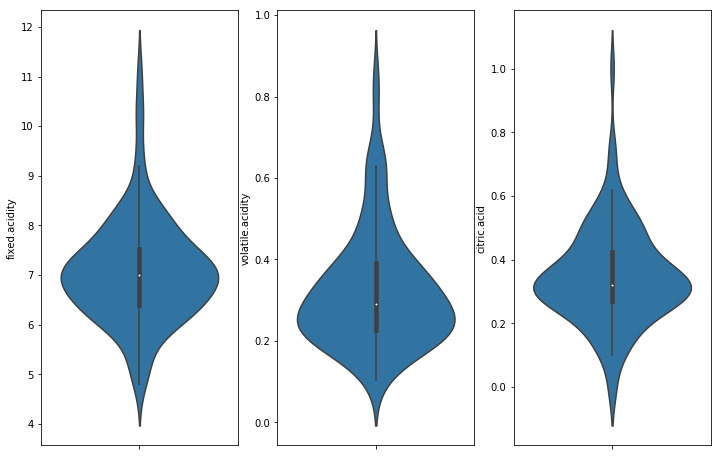

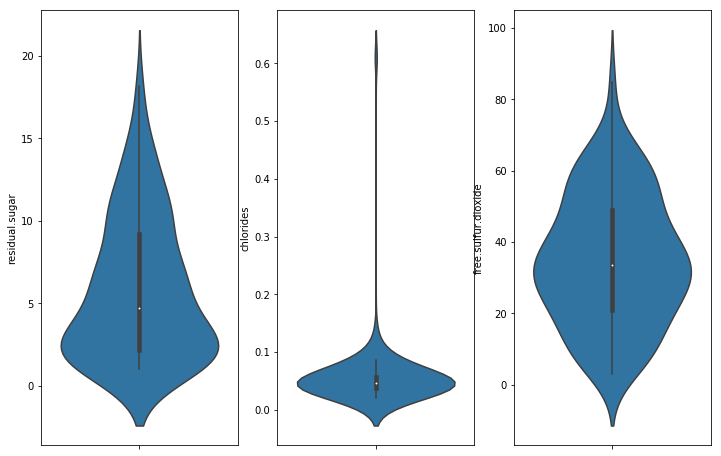

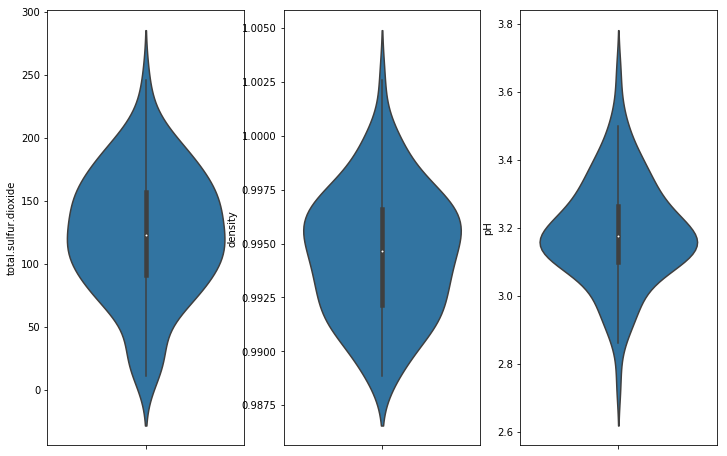

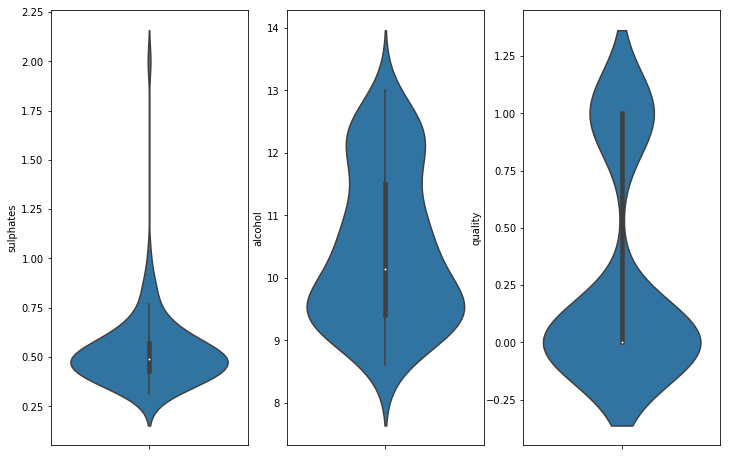

In [5]:
#create a dataframe with only continuous features

data = dataset_train.iloc[:,0:]

#get the names of all the columns
cols = data.columns

#Plot violin for all attributes in a 4x3 grid
n_cols = 3
n_rows = 4

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.violinplot(y=cols[i*n_cols+j], data=dataset_train, ax=ax[j])

chlorides and sulphates = 0.75
free.sulfur.dioxide and total.sulfur.dioxide = 0.71
density and alcohol = -0.69
residual.sugar and total.sulfur.dioxide = 0.58
alcohol and quality = 0.55
fixed.acidity and density = 0.54
residual.sugar and density = 0.54


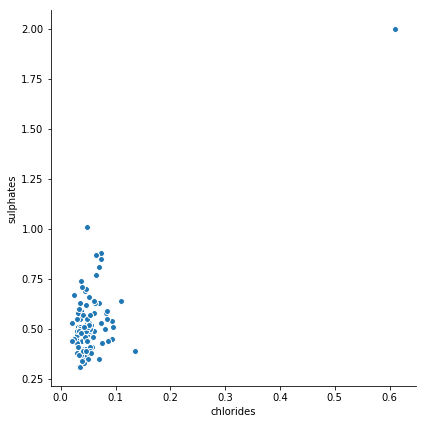

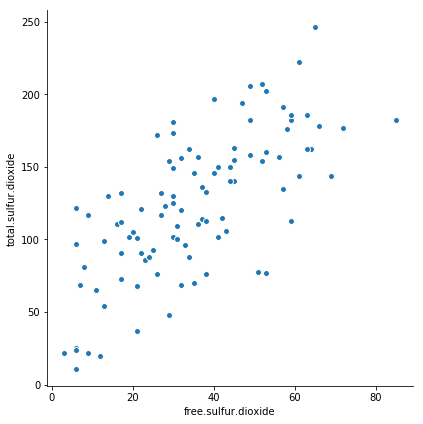

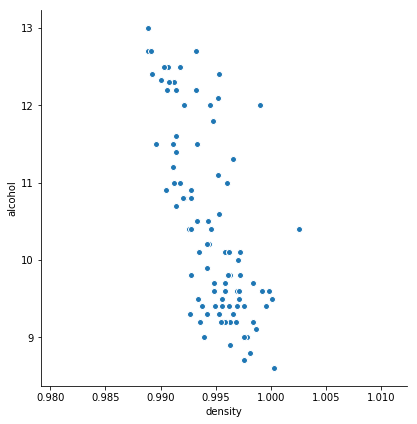

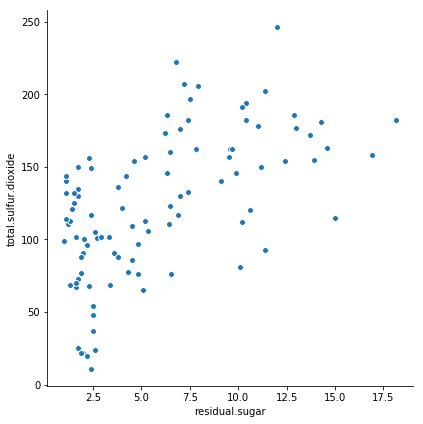

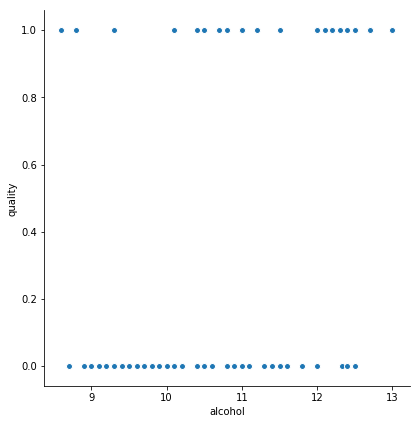

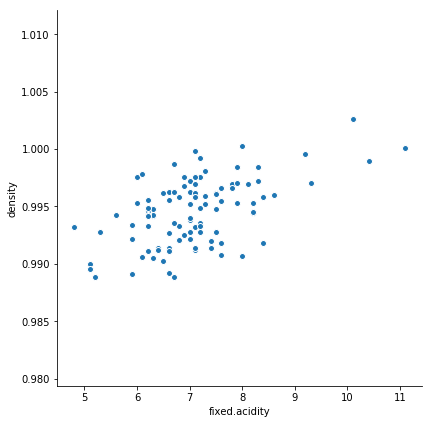

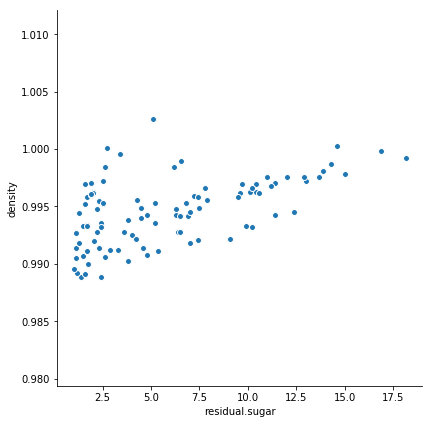

In [6]:
# Calculates Pearson correlation coefficient for all combinations
data_corr = data.corr()

# number of continuous fields
size = data_corr.shape[0]

# Set the threshold to select only highly correlated attributes (above 0.5)
threshold = 0.5

# List of pairs along with correlation above threshold
corr_list = []

# Search for the highly correlated pairs
for i in range(0,size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

# Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

# Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

# Scatter plot of only the highly correlated pairs
for v,i,j in s_corr_list:
    sns.pairplot(dataset_train, size=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

In [7]:
print('Skewness before correction: ')
print(dataset['chlorides'].skew())
dataset['chlorides'] = np.log(dataset['chlorides'])
print('Skewness after correction: ')
print(dataset['chlorides'].skew())

Skewness before correction: 
5.613255938657166
Skewness after correction: 
0.8993746118153867


In [8]:
# one-hot encoding using get_dummies from pandas
dataset_encoded = pd.get_dummies(dataset)

# rearrange columns
cols = list(dataset_encoded.columns.values) # Make a list of all of the columns in the dataframe
cols.pop(cols.index('quality')) # Remove quality from list
dataset_encoded = dataset_encoded[cols+['quality']] # Create new dataframe with columns in the order you want

#Display the first five rows to get a feel of the data
print(dataset.head(5))
print(dataset_encoded.head(5))

   fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            6.0              0.29         0.27             2.3  -3.123566   
1            7.4              0.60         0.26             2.1  -2.488915   
2            7.4              0.29         0.28            10.2  -3.442019   
3            7.8              0.46         0.26             1.9  -2.430418   
4            6.8              0.25         0.34             4.7  -3.473768   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 20.0                 117.0  0.98950  3.31       0.41   
1                 17.0                  91.0  0.99616  3.29       0.56   
2                 43.0                 138.0  0.99510  3.10       0.47   
3                 23.0                  53.0  0.99810  3.43       0.74   
4                 34.0                 134.0  0.99270  3.21       0.38   

   alcohol  quality  
0     12.7        1  
1      9.8        1  
2     10.6        1 

In [13]:
dataset_test = dataset_encoded.iloc[:n_test, :].reset_index(drop=True)
dataset_train = dataset_encoded.iloc[n_test:, :].reset_index(drop=True)

X_train = dataset_train.iloc[:n_test, :-1]
Y_train = dataset_train.iloc[:n_test, -1:]
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(Y_train)

X_test = dataset_test.iloc[:, :-1]
Y_test = dataset_test.iloc[:, -1:]

clean_X_train = scaler_x.transform(X_train)
clean_Y_train = scaler_y.transform(Y_train)

clean_X_test = scaler_x.transform(X_test)
clean_Y_test = scaler_y.transform(Y_test)

XY_train = np.concatenate((clean_X_train, clean_Y_train), axis=1)
XY_test = np.concatenate((clean_X_test, clean_Y_test), axis=1) # we will not touch this until the end

print(np.mean(XY_train, axis = 0))
print(np.var(XY_train, axis = 0))

[ 4.53526106e-16 -3.49720253e-17  1.72847847e-16 -2.88657986e-17
 -1.67643677e-16  6.44449771e-17  1.33226763e-16  1.04219966e-13
 -1.21680443e-15 -3.97459843e-16 -1.02584607e-15 -1.50990331e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
X_train.shape

(100, 11)

In [16]:
kf = KFold(n_splits=10, random_state=None, shuffle=False)

## 5.3 Support Vector Regression (SVR):
- Using C = [10, 11, 12, ..., 19]

In [20]:
Y_train

,quality
0,1
1,1
2,0
3,1
4,1
5,0
6,0
7,1
8,1
9,1


In [19]:
from sklearn.svm import SVR

svr_lin = SVR(kernel='linear', C=14)


y_pred = svr_lin.fit(X_train, Y_train.values.ravel()).predict(X_test)

print(y_pred)

[ 0.95536945  0.26648387  0.85160885  0.4314955   0.87583825  0.88726759
  0.83493852  0.90018878  0.92006957  0.86535678  1.04234309  0.55604383
  0.98244607 -0.02451475  0.37556919  0.88262132 -0.10296102  0.61179504
  0.97809797  0.78259429  0.96342461  0.20373063  0.56968868  0.91115582
  0.74777758  0.81519121  0.83691705  0.33694402 -0.28794124  0.42126946
  0.86786584  0.86714246  0.75789499  1.03694096  0.72556515  0.54607284
  0.81870961  0.79578072  0.77504171  0.63000444  0.83093875  0.84152526
  0.65843017  0.37662873  1.16243292 -0.01047733  0.1656652   0.94075812
  0.66759458  0.66318793  1.19894412  1.00549055  0.29391646  0.75469193
  1.00078438  0.2593913   0.75642441 -0.257999    0.76373839  0.32984815
  0.56217587  1.17510709  0.2975654   0.85981049  0.98423481  0.95615049
  0.33528837  0.50451661  0.79912158  0.9690225   0.96867639  0.89476192
  1.0322149   0.90762525  0.94123875  0.90128378  0.97198035  0.75716135
  0.82129861  0.98221753  0.72010224  0.7185956   1

## 5.5 Run models:

In [ ]:
import pickle

try:
    with open('../result/model_result', "rb") as f:
        model_result = pickle.load(f)
    
    for key, value in model_result.items():
        print("Model: %-10s MAE: %-10.8f" %(key, value))
        #print(key + " %s" % value)
except FileNotFoundError:
    model_result = {}

    for d in models:
        model = d['model']
        name = d['name']
        
        print("executing" + name)
        mae = []
        for train_idx, val_idx in kf.split(XY_train):
                X_train = XY_train[train_idx,:-1]
                X_val = XY_train[val_idx,:-1]
                Y_train = XY_train[train_idx,-1]
                Y_val = XY_train[val_idx,-1]
                model.fit(X_train,Y_train)
                pred = model.predict(X_val)
                inverse_pred = scaler_y.inverse_transform(pred)
                result = mean_absolute_error(scaler_y.inverse_transform(Y_val), np.around(inverse_pred))
                mae.append(result)

        mean = np.mean(mae)
        print(name + " %s" % mean)
        model_result[name] = mean
    
    with open('../result/model_result', "wb") as f:
        pickle.dump(model_result, f)

# Step 6: Analysis of Results
## 6.1 Select Best Model:
- Select the model that gives lowest MAE

**Result: **

- The best model is SVR with parameter C = 14

In [ ]:
keys = model_result.keys()
values = model_result.values()
#Plot the MAE of all models
fig, ax = plt.subplots()
plt.plot(values)
plt.xlabel('methods')
plt.ylabel('MAE')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys,rotation='vertical')
plt.show()

best_model_name = min(model_result.keys(), key=(lambda key: model_result[key]))
print('Model with minimum MAE: ' + best_model_name)


svr_model_result = {}
for k,v in model_result.items():
    if 'SVR' in k:
        svr_model_result[k] = v
        

svr_keys = svr_model_result.keys()
svr_values = svr_model_result.values()
#Plot the MAE of all models
fig, ax = plt.subplots()
plt.plot(svr_values)
plt.xlabel('methods')
plt.ylabel('MAE')
ax.set_xticks(range(len(svr_keys)))
ax.set_xticklabels(svr_keys,rotation='vertical')
plt.show()

## 6.2 Make Predictions:
- The SVR model is able to predict wine quality with 71% accuracy
- If we allow error of +- 1, the model is 100% accurate

In [ ]:
X = XY_train[:,:-1]
Y = XY_train[:,-1]

#Best model definition
best_model = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
best_model.fit(X,Y)

X_test = XY_test[:,:-1]
Y_test = XY_test[:,-1]
Y_predict = best_model.predict(X_test)

inverse_pred = scaler_y.inverse_transform(Y_predict)
predictions = np.around(inverse_pred)
targets = scaler_y.inverse_transform(Y_test)
result = mean_absolute_error(targets, predictions)

print("MAE: " + str(result))

percent_threshold = 0
accuracy = 0
for i in range(targets.shape[0]):
    if targets[i] - 1 <= predictions[i] and  predictions[i] <= targets[i] + 1:
        percent_threshold += 1
    if targets[i] == predictions[i]:
        accuracy += 1
        
print("Accuracy: " + str(accuracy/100))
print("Accuracy +- 1: " + str(percent_threshold/100))